# <center>CITS5508 Lab sheet 4: Abalone & Red Wine</center>
**Name: Wei Yang**<br>
**Student number: 21220208**<br>
**Date created:  16th April 2021**<br>
**Last modified: 23th April 2021**<br>

## 1. Introduction
This lab sheet consists of two projects. The first part is to train an AdaBoost Regressor for predictng the rings of ablone. The second is to train two Random Forest models using the original data and using the reduced-dimensional data respectively.

In [1]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import pairplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestRegressor

## 2.Project 1
The first project asks us to train an AdaBosst regressor with SVR to predict the rings of abalone and to compare the performance on training and test sets. 
### 2.1 Loading data

In [2]:
#Read data and save as dataframe
columns=["sex","length","diameter","height","whole_weight","shucked_weight","viscera_weight","shell_weight","rings"]
df1 = pd.read_csv("abalone.data",names=columns)
origin = df1

### 2.2 Data visualisation

In [3]:
#show the frist few row of the dataframe
df1.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
#It can be seen that there are 4176 instance and 9 columns(1 target and 8 features)
#The ring values are what we want our AdaBoost regressor to predict. 7 features are numerical and 1 is catagorical
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


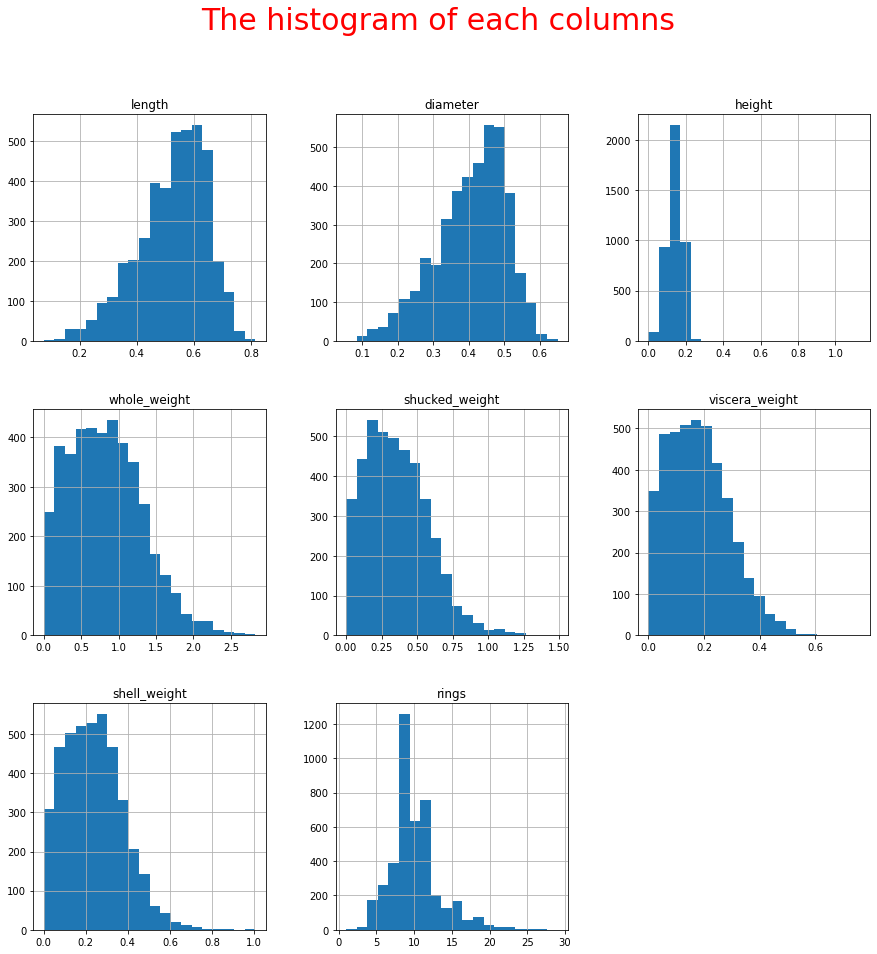

In [5]:
#plot the histogram of each column so as to display different features
df1.hist(bins=20, figsize=(15,15))
plt.suptitle("The histogram of each columns",fontsize=30, color = 'red')
plt.show()

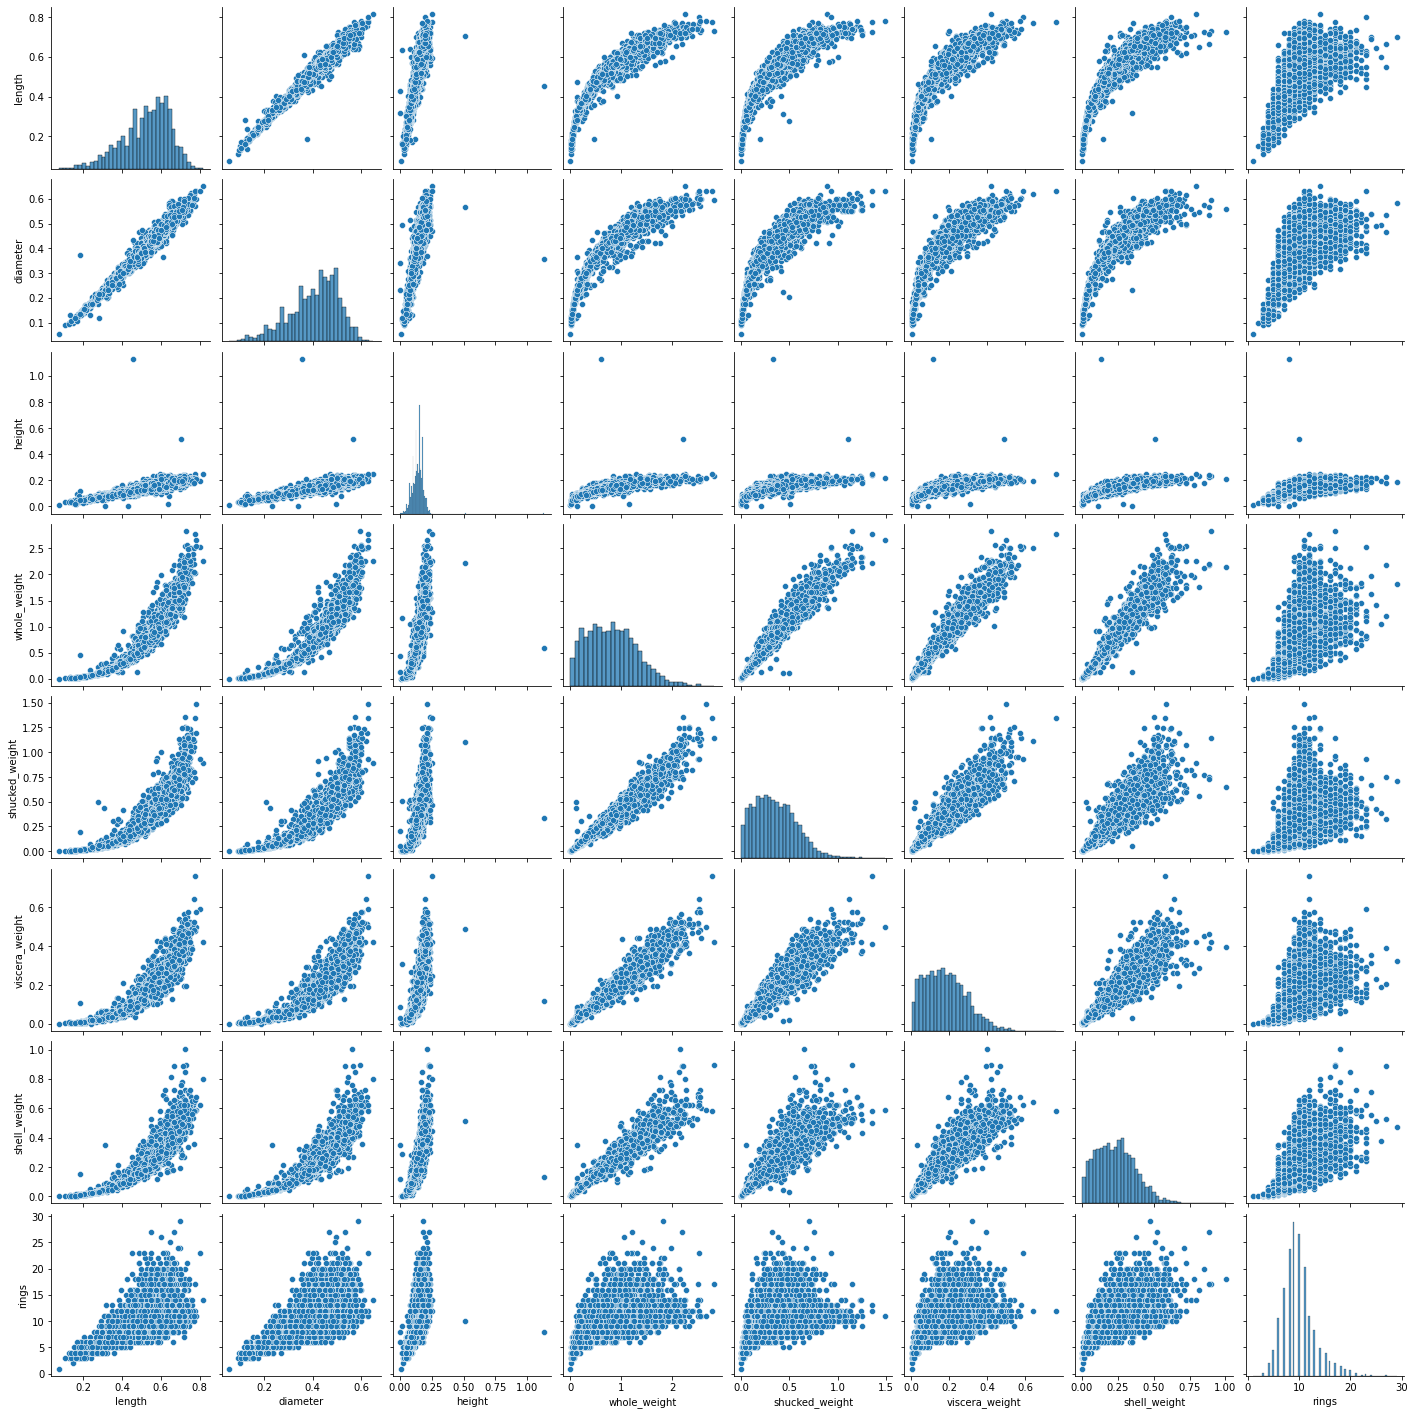

In [6]:
#Plot Scatter for each input and output pairs to see the correlation between each features and output
plot_features = list(df1.columns.values)
pairplot(df1[plot_features])

### 2.3 Data Cleaning and Transformation

#### 2.3.1 Feature Selection

It is asked to remove 2 features.There are two main criteria to determine which ones need to be deleted.
- All instance have the same value，which means it has no effect in training
- Features that are highly correlated to others. It means including the attribute does not provide additional information for the our model

1. According to the histogram, all features are well distributed.
2. According to the pair Scatter chart, it seems the strongest linear correlation occurs between the length and diameter attributes.This means that we can remove one of these attributes with a minimal loss. I decide to remove the length attribute, because diameter is a better feature to describe shape, which combines infromation like width and eccentricity. 
3. There is also a linear correlation between whole_weight and shucked_weight. The whole weight tend to be the sum of shucked weight, viscera weight and shell weight. I will remove the whole_weight feature, because the correlations between whole_weight and the other attributes seem to be stronger than those of shucked_weight.
4. Height is left-skewed,which is mainly due to outliers. It makes height looks correlated to other features. But after removing the two clear outliers, the strong correlation dispears. So, I keep the hight features.

In [7]:
# Remove the "length" and "whole_weight" attributes
df1_dropped = df1.drop(labels=["length","whole_weight"], axis=1)
df1_dropped = df1_dropped.reset_index(drop=True)

#### 2.3.2 One-hot Encoding

In [8]:
#use one-hot encoding to convert this column into numerical columns.
abalone = df1_dropped.replace(to_replace=["M","F"], value="A")
pd_1hots = pd.get_dummies(abalone["sex"], prefix="sex")
abalone_1hot = pd.concat([pd_1hots, abalone.drop(labels=["sex"], axis=1)], axis=1)
abalone_1hot.head()

,sex_A,sex_I,diameter,height,shucked_weight,viscera_weight,shell_weight,rings
0,1,0,0.365,0.095,0.2245,0.1010,0.150,15
1,1,0,0.265,0.090,0.0995,0.0485,0.070,7
2,1,0,0.420,0.135,0.2565,0.1415,0.210,9
3,1,0,0.365,0.125,0.2155,0.1140,0.155,10
4,0,1,0.255,0.080,0.0895,0.0395,0.055,7


#### 2.3.3  Dimensions of features comparasion
The dimensions of features and number of instances before and after data cleaning are reported as below:

In [9]:
print('\033[1;31m' + f"Before Data cleaning:\033[0m\nInstances: {origin.shape[0]}  Number of features: {origin.shape[1]}")
print('\033[1;31m' + f"After Data cleaning:\033[0m\nInstances: {abalone_1hot.shape[0]}  Number of features: {abalone_1hot.shape[1]}")

Before Data cleaning:
Instances: 4177  Number of features: 9
After Data cleaning:
Instances: 4177  Number of features: 8


### 2.4 AdaBoost Regressor – setup, training, and prediction
#### 2.4.1 Data splitting 

In [10]:
# Data were randomly split into 85/15 for the training and test sets. 
X_abalone = abalone_1hot.drop(labels=["rings"], axis = 1)
y_abalone = abalone_1hot["rings"]
X_train_abalone, X_test_abalone, y_train_abalone, y_test_abalone = train_test_split(X_abalone, y_abalone, test_size = 0.15, random_state = 42)
y_train_abalone = y_train_abalone.reset_index(drop=True)
X_test_abalone =X_test_abalone.reset_index(drop=True)
X_train_abalone =X_train_abalone.reset_index(drop=True)
y_test_abalone = y_test_abalone.reset_index(drop=True)

#### 2.4.2  Feature scaling 
As SVMs are sensitive to the feature scales, I use Standard Scaler to do scaling and generate scaled training and test input

In [11]:
#Using Standard Scaler to do scaling and generate scaled input
scaler = StandardScaler()
#Perform an appropriate feature scaling 
X_train_scaled_abalone = scaler.fit_transform(X_train_abalone)
X_test_scaled_abalone = scaler.transform(X_test_abalone)

#### 2.4.3 AdaBoost Regressor setup
For base estimator, the hyperparameters chosen for Grid search:<br>
- kernel : It is set to be "rbf".
- C: Regularization parameter. I choose it from "0.1,1,5,10". 
- gamma: Kernel coefficient for ‘rbf’. I choose between "scale" and "auto".
- degree: Degree of the polynomial kernel. I choose it from "1,2,3"<br>

For AdaBoostRegressor, the hyperparameters chosen for Grid search:<br>
- n_estimators : It is set to be 5.
- learning_rate: I choose it from "0.1,0.3,0.5,1.0". 
- loss: to use when updating the weights after each boosting iteration. I choose between "linear" and "square".<br>

The hyperparameters for SVR are set to be kernel="rbf", C=10, degree =1, gamma = "auto"<br>
The hyperparameters for AdaBoostRegressor are set to be n_estimators = 5, learning_rate=0.3, loss = "linear"


In [12]:
#Set up SVR with choosen hyperparameter
SVR_abalone = SVR(kernel="rbf", C=10, degree =1, gamma = "auto")
#Set up AdaBoostRegressor with choosen hyperparameter
Adaboost_abalone = AdaBoostRegressor(base_estimator = SVR_abalone, n_estimators = 5, learning_rate=0.3, loss = "linear")

#### 2.4.4 AdaBoost Regressor Training

In [13]:
#The regressor is trained on the scaled training set
Adaboost_abalone.fit(X_train_scaled_abalone, y_train_abalone)

AdaBoostRegressor(base_estimator=SVR(C=10, degree=1, gamma='auto'),
                  learning_rate=0.3, n_estimators=5)

#### 2.4.5 AdaBoost Regressor Prediction

In [14]:
#Make a function to calculate the MAE for intermediate models and the final model.
def makePredict(X,y,set):
    y_pred_list = []
    predictions = Adaboost_abalone.staged_predict(X)
    for prediction in predictions:
           MAE = mean_absolute_error(y,np.rint(prediction)) #Round the result to be integer
           y_pred_list.append(MAE)
    print('\033[1;30m' + f'MAE of {set} for intermediate models and the final model:' + '\033[0m')  
    for i in range(len(y_pred_list)):
        print(f"MAE for Model {i + 1}: {y_pred_list[i]:.5f}")
    return  y_pred_list

In [15]:
#Make prediction for test set and print out the MAE for each intermediate models
Pre_test_MAE = makePredict(X_test_scaled_abalone,y_test_abalone,"test set")

MAE of test set for intermediate models and the final model:
MAE for Model 1: 1.47209
MAE for Model 2: 1.47209
MAE for Model 3: 1.47687
MAE for Model 4: 1.47687
MAE for Model 5: 1.47368


In [16]:
#Make prediction for trianing set and print out the MAE for each intermediate models
Pre_train_MAE = makePredict(X_train_scaled_abalone,y_train_abalone,"training set")

MAE of training set for intermediate models and the final model:
MAE for Model 1: 1.40620
MAE for Model 2: 1.40620
MAE for Model 3: 1.39915
MAE for Model 4: 1.39859
MAE for Model 5: 1.40310


### 2.5 AdaBoostRegressor results and plots
#### 2.5.1 MAE plots

In [17]:
# Define a function to plot MAEs for the training and test sets 
def plotMAE(Pre_test_MAE,Pre_train_MAE):   
    figure(num=None, figsize=(15, 8))
    Labels=['Model-1', 'Model-2', 'Model-3',  'Model-4', 'Final Model']
    y_pos=np.arange(len(Labels))
    plt.bar(y_pos + 0, Pre_test_MAE,width=0.2, color = 'navy' )
    plt.bar(y_pos + 0.2,Pre_train_MAE, width=0.2,color = 'skyblue')
    plt.xticks(y_pos+0.1, Labels)
    plt.ylim(1.3,1.5)
    plt.legend(('test set','training set'))
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Intermediate Models')
    plt.title("MAEs for the training and test sets",fontsize=25, color = 'red')
    plt.show()

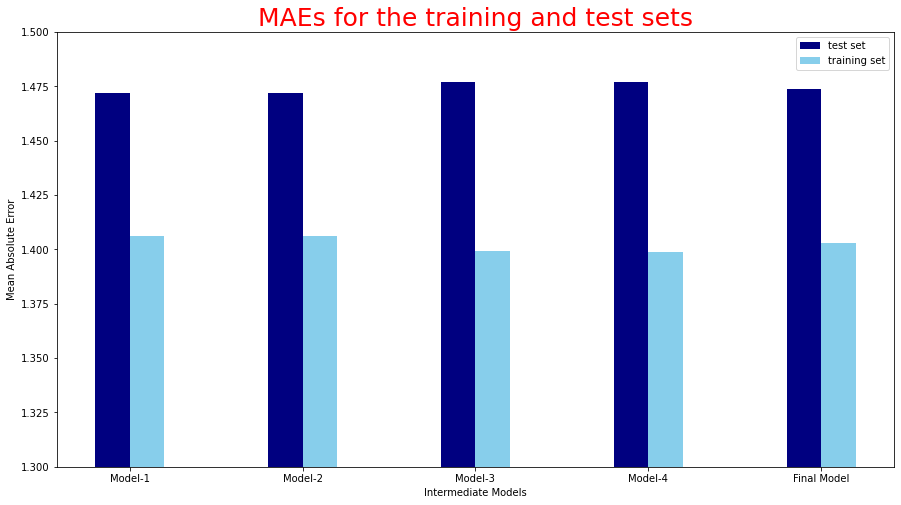

In [18]:
#Make the plot
plotMAE(Pre_test_MAE,Pre_train_MAE)

#### 2.5.2 Illustration of the prediction results

In [19]:
#Make prediction for test set
y_pred_test_raw = Adaboost_abalone.predict(X_test_scaled_abalone)
#Round the result to be integer
y_pred_test_rounded_abalone = pd.Series(np.rint(y_pred_test_raw).astype(int))

In [20]:
#Make prediction for train set
y_pred_train_raw = Adaboost_abalone.predict(X_train_scaled_abalone)
#Round the result to be integer
y_pred_train_rounded_abalone = pd.Series(np.rint(y_pred_train_raw).astype(int))

In [21]:
#Define a function to illustrate how good our prediction are for training and test set. I use scatter plot and regline to show the result. 
def plot_figure(y_act1,y_pre1,y_act2,y_pre2,title):
    result1 = pd.concat([y_act1.to_frame("y_pred_train") ,  y_pre1.to_frame('y_train')], axis=1)
    result2 = pd.concat([y_act2.to_frame("y_pred_test"),  y_pre2.to_frame('y_test')], axis=1)  
    fig, axs = plt.subplots(1, 2, constrained_layout=True,figsize=(14, 8))
    plt.suptitle(title,fontsize=25, color = 'red')
    sns.regplot(ax=axs[0],x="y_pred_train", y="y_train", data=result1)
    axs[0].set_title("Scatter for Training set")
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')
    sns.regplot(ax=axs[1],x="y_pred_test", y="y_test", data=result2)
    axs[1].set_xlabel('Predicted')
    axs[1].set_title("Scatter for test set")
    axs[1].set_ylabel('Actual')
    plt.show()

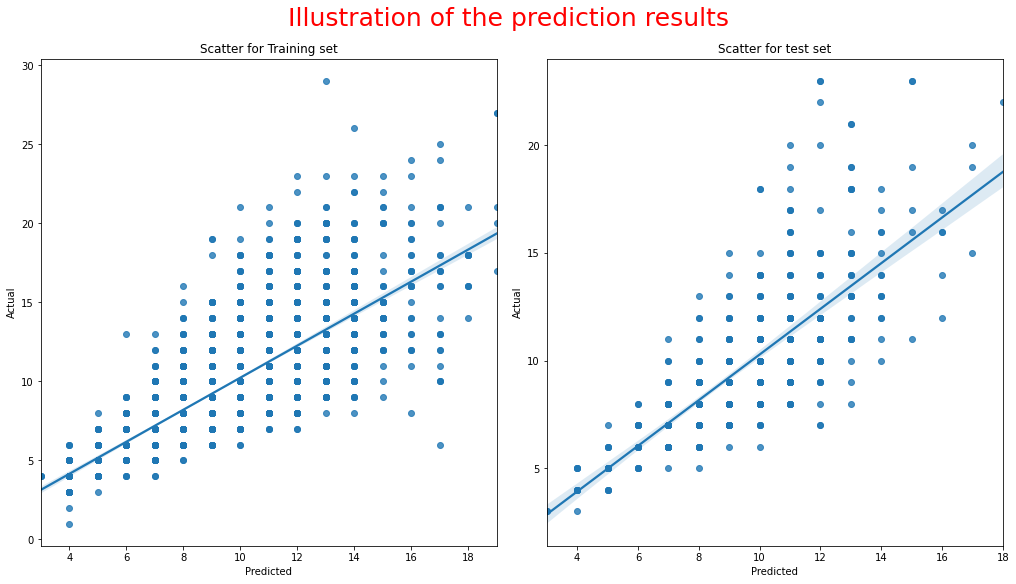

In [22]:
#Call the function to plot the illustration
plot_figure(y_pred_train_rounded_abalone, y_train_abalone,y_pred_test_rounded_abalone,y_test_abalone,"Illustration of the prediction results")

#### 2.5.3 Raw prediction errors for final model

In [23]:
#Calculate the raw prediction error for training set
raw_error_train_abalone = y_pred_train_rounded_abalone-y_train_abalone
#Calculate the raw prediction error for test set
raw_error_test_abalone = y_pred_test_rounded_abalone-y_test_abalone

In [24]:
#Define a function to plot the distributions of the raw prediction errors of the final model 
def plot_distributions(raw_train,raw_test,title):
    fig, axs = plt.subplots(2, 1, constrained_layout=True,figsize=(12, 12))
    plt.sca(axs[0])
    plt.xticks(range(-20, 20))
    plt.sca(axs[1])
    plt.xticks(range(-20, 20))
    plt.suptitle(title,fontsize=25, color = 'red')
    axs[0].hist(raw_train, bins=55)
    axs[0].set_title("Raw prediction errors for training set")
    axs[0].set_xlabel('Raw error')
    axs[0].set_ylabel('Count')
    axs[1].hist(raw_test, bins=33)
    axs[1].set_xlabel('raw error')
    axs[1].set_title("Raw prediction errors for test set")
    axs[1].set_ylabel('Count')
    plt.show()


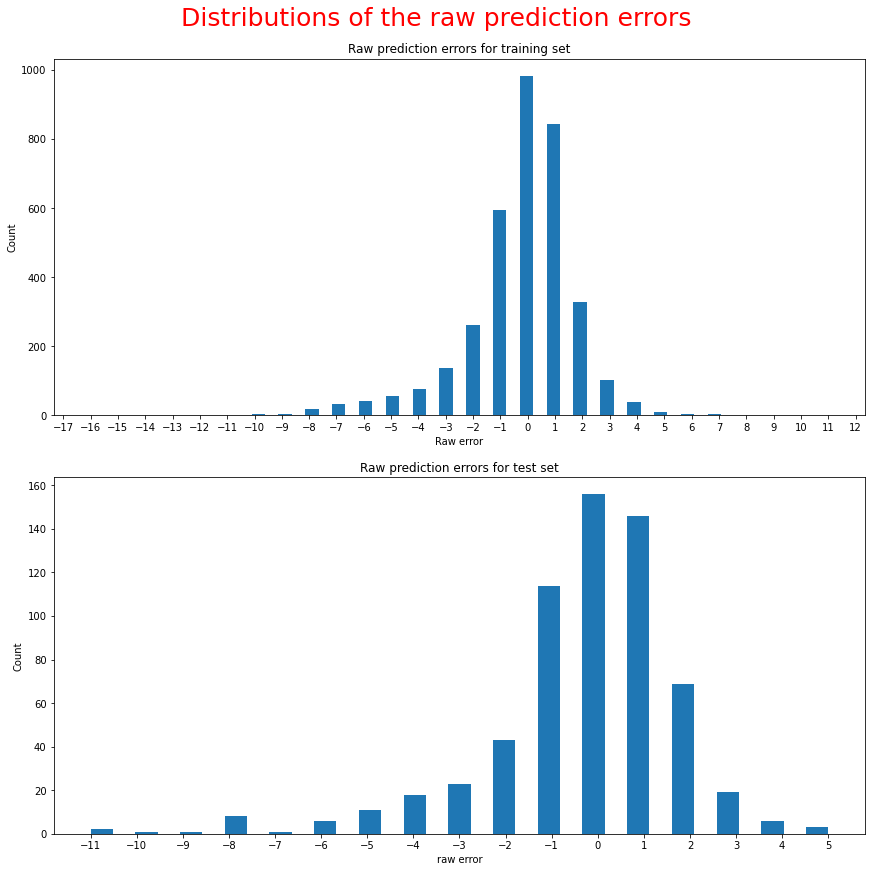

In [25]:
#plot the distributions of the raw prediction errors of the final model
plot_distributions(raw_error_train_abalone,raw_error_test_abalone,"Distributions of the raw prediction errors")

### 2.6 Conclusion

There are some of interesting points of the AdaBoost model.

1. Generally the MAEs show an decrising trend as new estimators added in the AdaBoost ensemble for both training and test sets. But there is occasionally some fluctuations. The MAEs of training set are little bit smaller than that of test set.

2. Naturally, these histograms peak near the 0 point. When raw error is small(less than ±2), it tend to overestimate the rings. Conversely，when raw error is big(bigger than ±2), it is more likely to be underestimated. Overall, regressors have a tendency to underestimate, rather than overestimate, the target values.


## 3.Project 2
This project is to train two Random Forest models using the original data and using the reduced-dimensional data respectively.
### 3.1 Loading data

In [26]:
#Read data and save as dataframe
df2 = pd.read_csv("winequality-red.csv", sep=';')

### 3.2 Data visualisation

In [27]:
#show the frist few row of the dataframe
df2.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [28]:
#It can be seen that there are 1599 instance and 12 columns(1 target and 11 features)
#The quality is what we want our Random Forest to predict. 11 features are all numerical
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


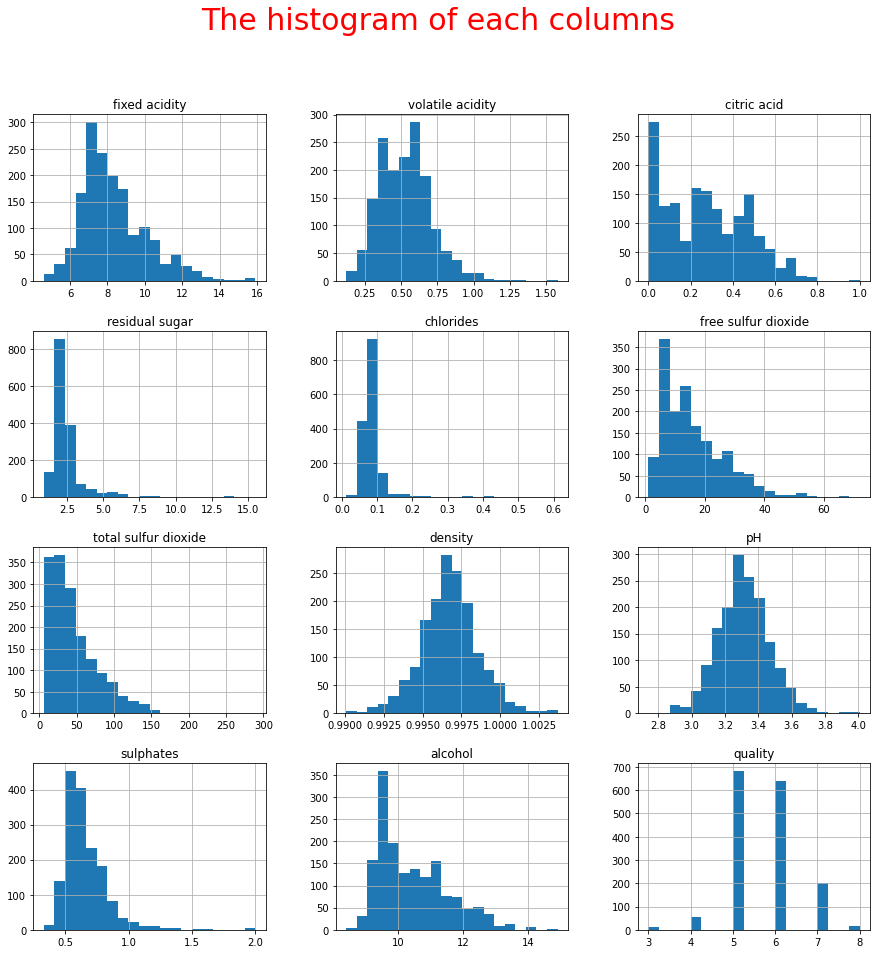

In [29]:
#plot the histogram of each column so as to display different features
df2.hist(bins=20, figsize=(15,15))
plt.suptitle("The histogram of each columns",fontsize=30, color = 'red')
plt.show()

### 3.3 Data splitting

In [30]:
# Data were randomly split into 85/15 for the training and test sets. 
X_wine = df2.drop(labels=["quality"], axis = 1)
y_wine = df2["quality"]
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, test_size = 0.15, random_state = 42)
y_train_wine = y_train_wine.reset_index(drop=True)
X_test_wine =X_test_wine.reset_index(drop=True)
X_train_wine =X_train_wine.reset_index(drop=True)
y_test_wine = y_test_wine.reset_index(drop=True)

### 3.4  Feature scaling 
Because the result of Random Forest regressor is not affected by the scaling. So for tis project I will not performing scaling on the data.

### 3.5 Random Forest with all features
#### 3.5.1 Model set and training

For the Random Forest regressor, the hyperparameters chosen for Grid search:<br>
- max_depth: It choose it from 6, 9, 12, 20.
- min_impurity_decrease: I choose it from "0, 0.3, 0.5, 1.0". 
- min_samples_split: The minimum number of samples required to split an internal node. I choos from 1,2,3,4.
- max_features: choose from 'auto', 'sqrt', 'log2'
- criterion: I choose"mae".<br>

The hyperparameters for RandomForestRegressor are set to be n_estimators=50, max_depth=12,min_impurity_decrease=0, min_samples_split=2, max_features= 'sqrt',criterion="mae", random_state=42, n_jobs=-1<br>

In [31]:
##Set up RandomForestRegressor with choosen hyperparameter
rforest_reg = RandomForestRegressor(n_estimators=50, max_depth=12, min_impurity_decrease=0, min_samples_split=2, max_features= 'sqrt',criterion="mae", random_state=42, n_jobs=-1)
#Train the model with training set
rforest_reg.fit(X_train_wine,y_train_wine)

RandomForestRegressor(criterion='mae', max_depth=12, max_features='sqrt',
                      min_impurity_decrease=0, n_estimators=50, n_jobs=-1,
                      random_state=42)

#### 3.5.2 Prediction and presentation

In [32]:
#Make prediction for test set and then round the result to be integer
y_pred_test_wine = pd.Series(np.rint(rforest_reg.predict(X_test_wine)))
#Make prediction for training set and then round the result to be integer
y_pred_train_wine = pd.Series(np.rint(rforest_reg.predict(X_train_wine)))

In [33]:
# MAEs on the training and test sets (on the original data) were computed and reported below.
MAE_test_wine = mean_absolute_error(y_test_wine, y_pred_test_wine)
MAE_train_wine = mean_absolute_error(y_train_wine, y_pred_train_wine)
print(f"The mean absolute error for test set is roughly {MAE_test_wine:.5f}.")
print(f"The mean absolute error for training set is roughly {MAE_train_wine:.5f}.")

The mean absolute error for test set is roughly 0.45833.
The mean absolute error for training set is roughly 0.31420.


In [34]:
# Calculate the raw error of training and test sets
raw_training_wine = y_pred_train_wine- y_train_wine
raw_test_wine = y_pred_test_wine - y_test_wine

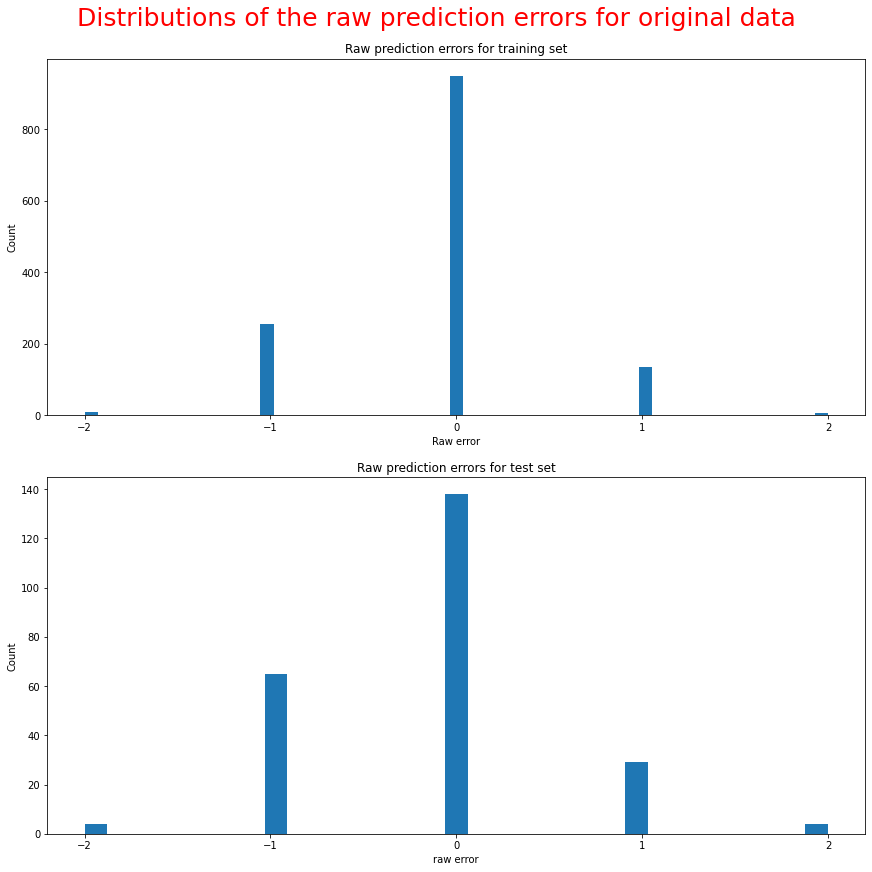

In [35]:
#plot the distributions of the raw prediction errors
plot_distributions(raw_training_wine,raw_test_wine,"Distributions of the raw prediction errors for original data")

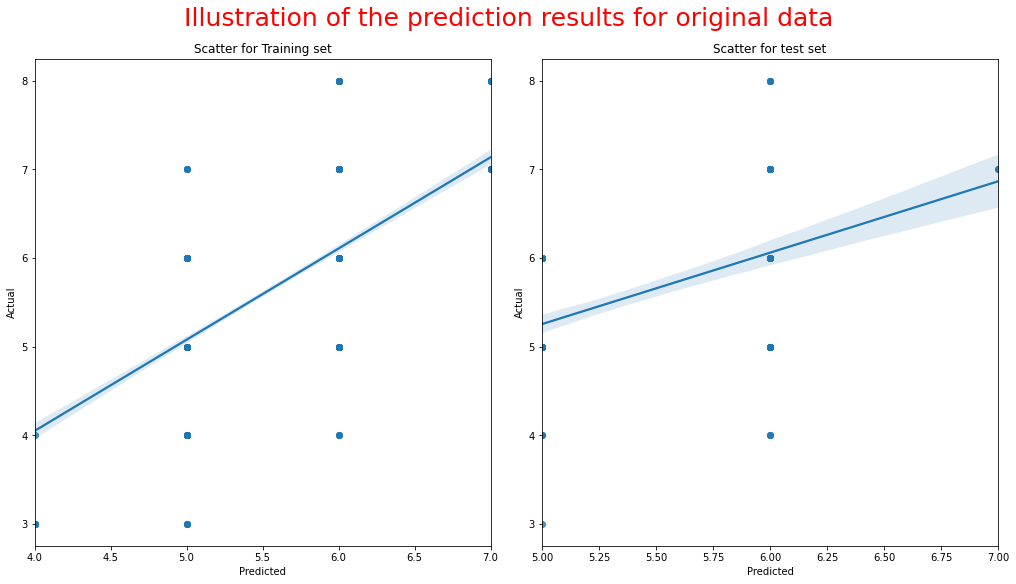

In [36]:
#Illustration of the prediction results
plot_figure(y_pred_train_wine, y_train_wine,y_pred_test_wine,y_test_wine,"Illustration of the prediction results for original data")

### 3.6 Feature importance & dimensionality reduction

In [37]:
#Calculate the importance of each features and the results are printted out below
#Calculate the score of each features and add them in a list.
scores = []
for name, score in zip(X_test_wine.columns.values, rforest_reg.feature_importances_):
    scores.append([score, name])
#Print the result
print ("The total inportance of each features:")
for x in scores:
    print (f"\"{x[1]}\": {x[0]:.4f}")

The total inportance of each features:
"fixed acidity": 0.0397
"volatile acidity": 0.1215
"citric acid": 0.0481
"residual sugar": 0.0413
"chlorides": 0.0535
"free sulfur dioxide": 0.0301
"total sulfur dioxide": 0.1057
"density": 0.0869
"pH": 0.0400
"sulphates": 0.1765
"alcohol": 0.2567


In [38]:
#Select important features with importance values above 5%
total = 0;
important_attributes = []
for result in scores:
    if (result[0] >= 0.05):
        important_attributes.append(result[1])
        total =total +result[0]
print (f"There are {len(important_attributes)} features remaining  which are {important_attributes}")
print (f"The total feature importance value that is retained after your dimension reduction step: {total*100:.2f} %")

There are 6 features remaining  which are ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
The total feature importance value that is retained after your dimension reduction step: 80.08 %


In [39]:
#Remove the features which is not important and remain important ones
X_reduced_train_wine = X_train_wine[important_attributes]
X_reduced_test_wine = X_test_wine[important_attributes]

### 3.7 Random Forest with selected model
#### 3.7.1 Model set and train

In [40]:
#Train the model with reduced training set
rforest_reg_reduced = rforest_reg
rforest_reg_reduced.fit(X_reduced_train_wine,y_train_wine)

RandomForestRegressor(criterion='mae', max_depth=12, max_features='sqrt',
                      min_impurity_decrease=0, n_estimators=50, n_jobs=-1,
                      random_state=42)

#### 3.7.2 Prediction and presentation

In [41]:
#Make prediction for training set and then round the result to be integer
y_pred_reduced_train_wine = pd.Series(np.rint(rforest_reg_reduced.predict(X_reduced_train_wine)))
#Make prediction for test set and then round the result to be integer
y_pred_reduced_test_wine = pd.Series(np.rint(rforest_reg_reduced.predict(X_reduced_test_wine)))

# MAEs on the training and test sets (on the original data) were computed and reported below.
reduced_model_error_train = mean_absolute_error(y_train_wine, y_pred_reduced_train_wine )
reduced_model_error_test = mean_absolute_error(y_test_wine, y_pred_reduced_test_wine)

#Print the result
print(f"The MAE of the reduced random forest regressor for training set is roughly {reduced_model_error_train:.7f}.")
print(f"The MAE of the reduced random forest regressor  for test set is roughly {reduced_model_error_test:.7f}.")

The MAE of the reduced random forest regressor for training set is roughly 0.3267108.
The MAE of the reduced random forest regressor  for test set is roughly 0.4708333.


In [42]:
# Calculate the raw error of training and test sets
raw_training_errors_reduced = y_pred_reduced_train_wine - y_train_wine
raw_test_errors_reduced = y_pred_reduced_test_wine - y_test_wine

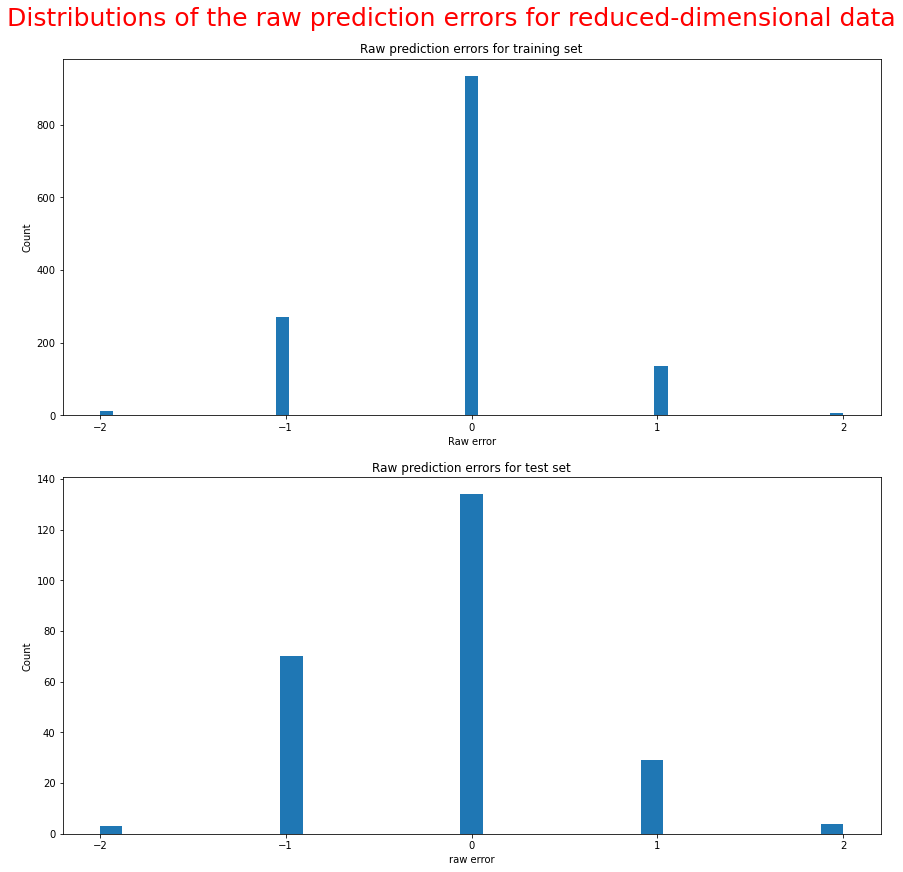

In [43]:
#plot the distributions of the raw prediction errors
plot_distributions(raw_training_errors_reduced,raw_test_errors_reduced,"Distributions of the raw prediction errors for reduced-dimensional data")

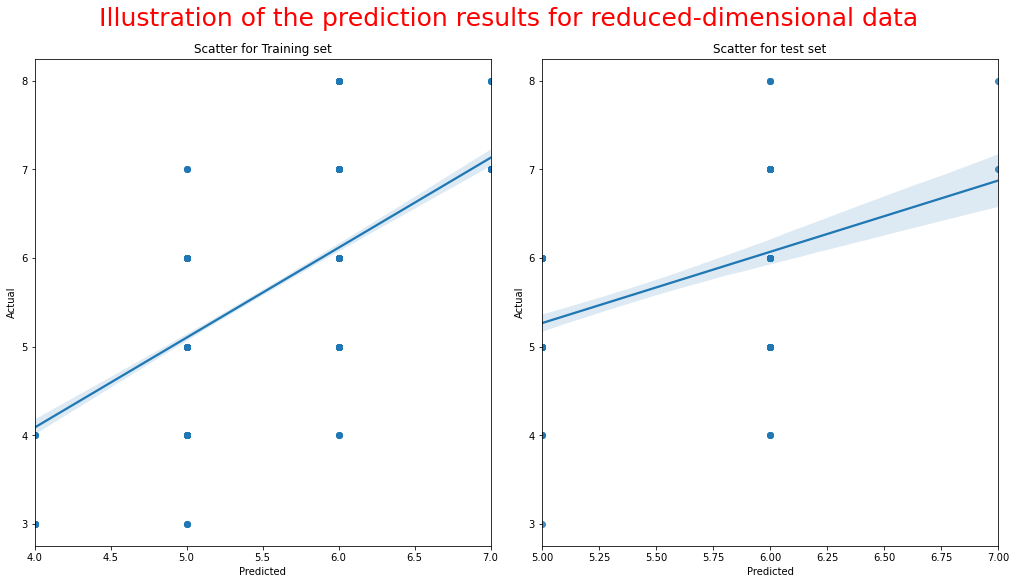

In [44]:
#Illustration of the prediction results
plot_figure(y_pred_reduced_train_wine, y_train_wine,y_pred_reduced_test_wine,y_test_wine,"Illustration of the prediction results for reduced-dimensional data")

### 3.8 Conclusion

Accordling to the results:
1. According to the importance of each feature, I deleted 5 of them and remain 6.
2. The imporance of features related to hyperparameters we choose. The more the model tend to overfit, the more features will play inportant roles.
3. After the deletion of features, totally around 80% feature importance remains
4. The MAEs(for test set and training set) for models before and after the feature removal are similar, with deleted one slightly larger than original one.

In [45]:
print('\033[1;31m' + 'MAEs for original model: ' + '\033[0m')
print(f"The MAE of the original model for test set is roughly {MAE_test_wine:.5f}.")
print(f"The MAE of the original model for training set is roughly {MAE_train_wine:.5f}.")
print("--------------------------------------")
print('\033[1;31m' + 'MAEs for reduced model: ' + '\033[0m')
print(f"The MAE of the reduced model for training set is roughly {reduced_model_error_train:.7f}.")
print(f"The MAE of the reduced model for test set is roughly {reduced_model_error_test:.7f}.")

MAEs for original model: 
The MAE of the original model for test set is roughly 0.45833.
The MAE of the original model for training set is roughly 0.31420.
--------------------------------------
MAEs for reduced model: 
The MAE of the reduced model for training set is roughly 0.3267108.
The MAE of the reduced model for test set is roughly 0.4708333.
